# **Team 8: the 3rd Bulgarian empire - Iteration 3 Notebook**
### Predicting Dwelling Restoration Needs
You are a team of data analysts working for RenovateNow, a property management company specializing in acquiring enchanted dwellings that require restoration. The company wants to streamline its selection process by predicting whether a dwelling requires significant restoration (NeedsRestoration = True) or not (NeedsRestoration = False). Additionally, they want to refine their understanding of trade values by creating a more accurate regression model. 

In [288]:
# General & data preparation
import pandas as pd

# Data vizualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model and evaluation
import sklearn as scikit_learn
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [289]:
# Load the datasets
df_it2 = pd.read_csv("Data/set8_it2_cleaned.csv")
df_it3 = pd.read_csv("Data/set8_it3.csv")

## **DATA UNDERSTANDING - add on dataset**

In [290]:
df_it2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DI                   2318 non-null   int64  
 1   TradeValue           2318 non-null   float64
 2   RealmType            2318 non-null   object 
 3   Enclave              2318 non-null   object 
 4   LivingQuarters       2318 non-null   float64
 5   ParcelSize           2318 non-null   float64
 6   ParcelSizeUnit       2318 non-null   object 
 7   StructuralIntegrity  2318 non-null   int64  
 8   ExteriorCharm        2318 non-null   object 
 9   Downpayment          2318 non-null   float64
 10  LoanAmount           2318 non-null   float64
 11  MonthlyPayment       2318 non-null   float64
 12  AffordableDwelling   2318 non-null   int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 235.6+ KB


In [291]:
df_it3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   DI              2363 non-null   int64
 1   Craftsmanship   2363 non-null   int64
 2   EraConstructed  2363 non-null   int64
dtypes: int64(3)
memory usage: 55.5 KB


## **DATA PREPARATION**
* Initial merging of the cleaned dataset and the add-on dataset
* Cleaning duplicates to not have any missing values
* Setting initial calculations based on the income, loan, downpayments, etc

In [292]:
# Remove duplicate rows
df_it3 = df_it3.drop_duplicates()

# left merge on the cleaned dataset
df = df_it2.merge(df_it3, on='DI', how='left', indicator=True)

In [293]:
# Check how many rows have missing values after the merge
missing_after_merge = df[df.isnull().any(axis=1)]
print(f"Number of rows with missing values after merge: {len(missing_after_merge)}")

# Count how many values in the DI column were not matched
unmatched_keys = df['DI'].isna().sum()
print(f"Number of unmatched keys in 'DI': {unmatched_keys}")

Number of rows with missing values after merge: 0
Number of unmatched keys in 'DI': 0


In [294]:
df.sample(4)

,DI,TradeValue,RealmType,Enclave,LivingQuarters,ParcelSize,ParcelSizeUnit,StructuralIntegrity,ExteriorCharm,Downpayment,LoanAmount,MonthlyPayment,AffordableDwelling,Craftsmanship,EraConstructed,_merge
752,758,78000.0,GnomeBurough,Petalbridge,691.0,6756.0,sqft,6,Common,15600.0,62400.0,297.907144,1,5,1058,both
63,63,192000.0,Meadowlands,Dreamweaver,976.0,3182.0,sqft,5,Gleaming,38400.0,153600.0,733.309894,1,8,1757,both
923,930,255000.0,AetherIsles,Wyverncliff,1378.0,8640.0,sqft,5,Gleaming,51000.0,204000.0,973.927203,0,8,1733,both
906,913,166800.0,Meadowlands,Dragonspire,1207.0,13200.0,sqft,6,Common,33360.0,133440.0,637.062970,1,6,1390,both


A dwelling needs restoration if it was built before 1300 and if the StructuralIntegrity is 6 or less.

In [295]:
# Create NeedsRestoration column with 1 being that the dwelling needs restoration and 0 meaning that it doesn't.
df['NeedsRestoration'] = ((df['EraConstructed'] < 1300) & (df['StructuralIntegrity'] <= 6)).astype(int)

# Display the first few rows of the merged DataFrame
df.head(3)

,DI,TradeValue,RealmType,Enclave,LivingQuarters,ParcelSize,ParcelSizeUnit,StructuralIntegrity,ExteriorCharm,Downpayment,LoanAmount,MonthlyPayment,AffordableDwelling,Craftsmanship,EraConstructed,_merge,NeedsRestoration
0,0,125000.0,Meadowlands,Shadowmere,1032.0,9280.0,sqft,6,Common,25000.0,100000.0,477.415295,1,5,1294,both,1
1,1,250000.0,Meadowlands,Ravenstone,1933.0,11170.0,sqft,5,Common,50000.0,200000.0,954.830591,0,7,1442,both,0
2,2,130000.0,GnomeBurough,Petalbridge,1012.0,5500.0,sqft,7,Common,26000.0,104000.0,496.511907,1,5,1052,both,0


In [296]:
df.describe()

,DI,TradeValue,LivingQuarters,ParcelSize,StructuralIntegrity,Downpayment,LoanAmount,MonthlyPayment,AffordableDwelling,Craftsmanship,EraConstructed,NeedsRestoration
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,1169.446074,182213.303279,1155.320104,10060.294507,5.566005,36442.660656,145770.642623,695.931344,0.692839,6.118637,1409.698016,0.220449
std,676.195944,82064.948640,386.398111,7158.773125,1.107786,16412.989728,65651.958912,313.432494,0.461416,1.413660,231.823354,0.414639
min,0.000000,12789.000000,256.000000,1470.000000,1.000000,2557.800000,10231.200000,48.845314,0.000000,1.000000,887.000000,0.000000
25%,583.250000,129900.000000,879.000000,7410.250000,5.000000,25980.000000,103920.000000,496.129975,0.000000,5.000000,1228.000000,0.000000
50%,1170.500000,160500.000000,1110.500000,9378.500000,5.000000,32100.000000,128400.000000,613.001239,1.000000,6.000000,1396.000000,0.000000
75%,1753.750000,213220.750000,1329.000000,11546.250000,6.000000,42644.150000,170576.600000,814.358779,1.000000,7.000000,1617.750000,0.000000
max,2339.000000,755000.000000,4339.000000,164660.000000,9.000000,151000.000000,604000.000000,2883.588385,1.000000,10.000000,1799.000000,1.000000


The newly merged dataset consists of 2,318 rows, with an average trade value of approximately 182,213. This indicates a diverse range of property values, with some reaching up to 755,000. The dataset reveals significant variability in key features. The Living Quarters with mean size 1,155, with a range from 386  to 4,339, highlighting differences in living space across properties. Parcel Size ranges from 1,470 to 164,660, showing a wide variety in land sizes. Structural Integrity with an average score around 5.6, suggesting most properties are moderately well-maintained.

## **DATA UNDERSTANDING**

Starting with a correlation heatmap to have a visual overview of how various numerical features relate to one another. LivingQuarters shows a strong positive correlation with TradeValue (0.69), indicating that larger dwellings tend to be more valuable (as determined since Iteration 1). Even stronger is the correlation between Craftsmanship and TradeValue (0.80), suggesting that higher craftsmanship significantly boosts property value. While not included in this numeric heatmap, categorical features like RealmTyp, Enclave and ExteriorCharm should also be investigated further, as from the previous Iterations we know they could be important drivers of value. Let’s look more in detail the relationship of TradeValue with some of the other features. 

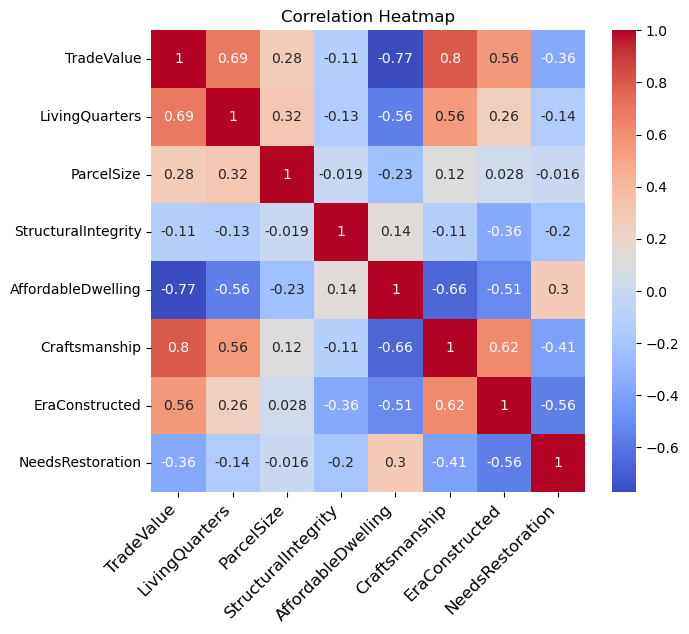

In [297]:
# We are transforming the categorical data into numerical using the label encoder
df2 = df.copy()
df2 = df2.drop(columns=["ParcelSizeUnit", "DI", "Downpayment", "MonthlyPayment", "LoanAmount", "RealmType", "Enclave", "ExteriorCharm", "_merge"])

# Visualize the correlation with a heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(df2.corr(), annot=True, cmap="coolwarm")
plt.xticks(ha='right', rotation=45, fontsize=12)
plt.title("Correlation Heatmap")
plt.show()

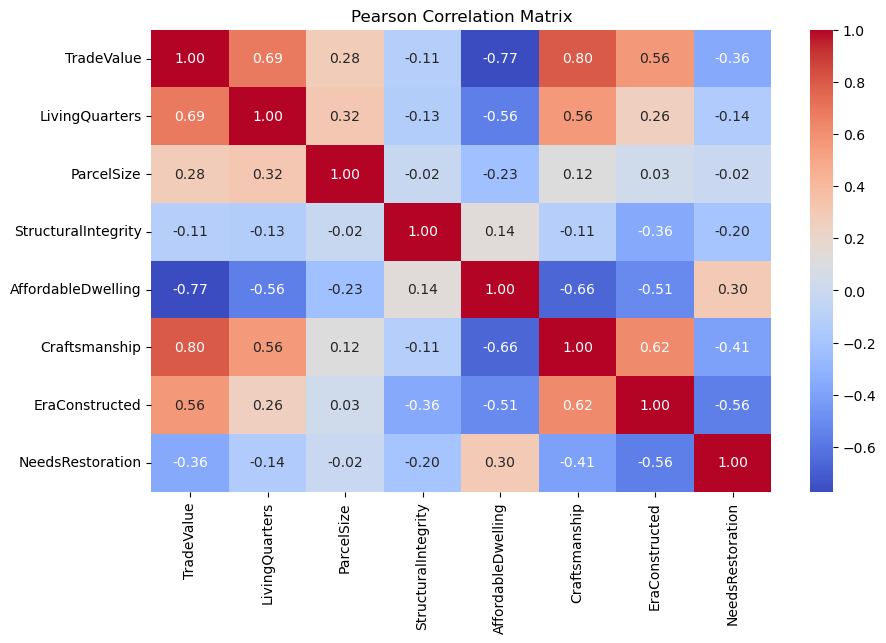

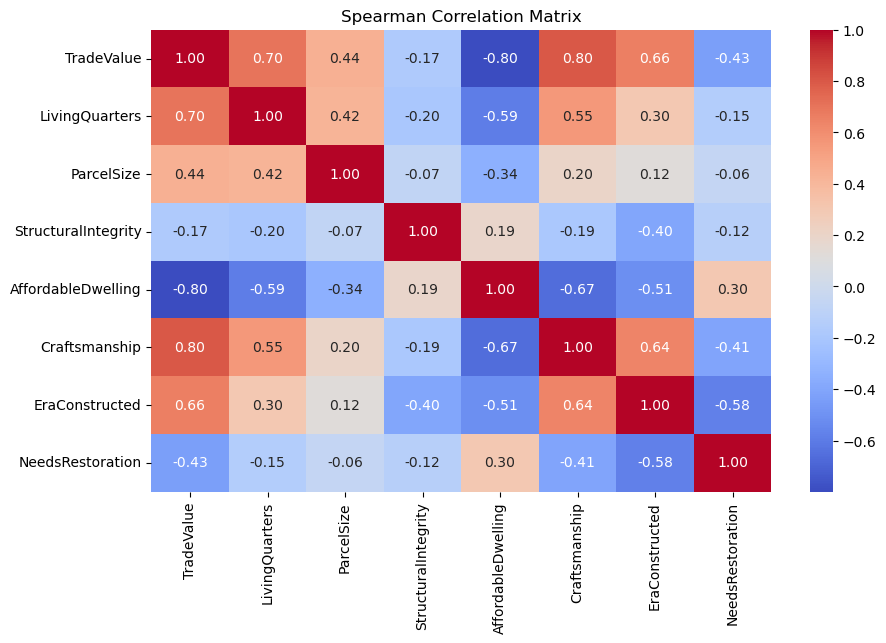

In [298]:
# Pearson Correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df2.corr(method='pearson'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

# Spearman Correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df2.corr(method='spearman'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

Starting with the relationship between TradeValue and LivingQuarters showcased with this scatterplot.  We see a positive trend, indicating that as the size of the living quarters increases, the trade value of the property tends to rise. This suggests that larger living spaces are generally associated with higher property values (as mentioned several times). While the overall trend is positive, there is noticeable variability. Properties with similar living quarters can have different trade values, likely due to other influencing factors such as location, condition, etc.

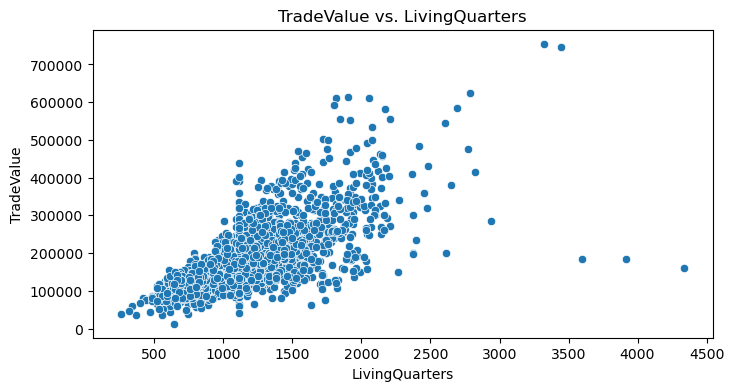

In [299]:
# Scatterplot for TradeValue vs. LivingQuarters
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df, x='LivingQuarters', y='TradeValue')
plt.title('TradeValue vs. LivingQuarters')
plt.show()

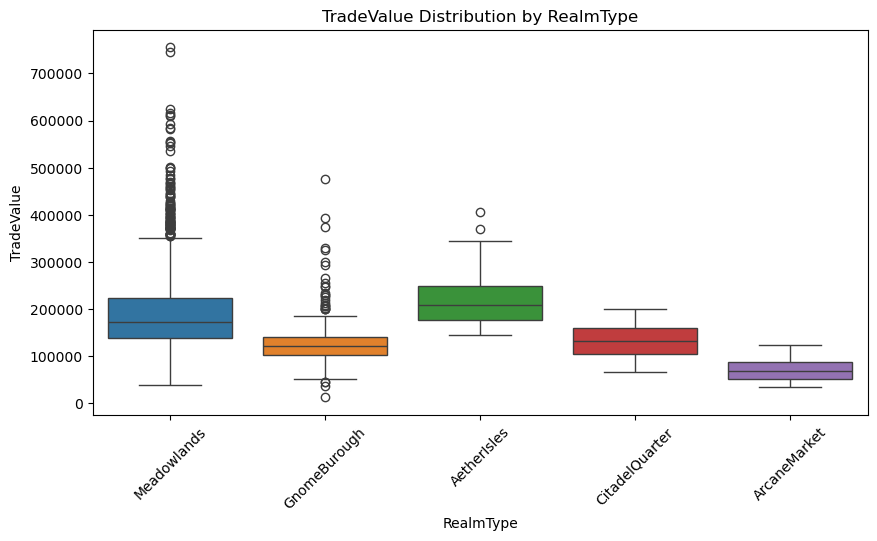

In [300]:
# Violin Plot for TradeValue vs. RealmType (to see value distribution across different realms)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='RealmType', y='TradeValue', hue='RealmType')
plt.title('TradeValue Distribution by RealmType')
plt.xticks(rotation=45)
plt.show()

Lastly on TradeValue trends, we will see a strong positive connection with Craftsmanship. As craftsmanship ratings increase, so does the median trade value of the properties, with the spread of values also becoming wider at higher levels. Lower craftsmanship levels (1–4) have relatively low and more tightly clustered trade values, while higher levels (especially 8–10) not only have significantly greater value but also show more variability. This suggests that craftsmanship is a key influence of dwellings trade value.

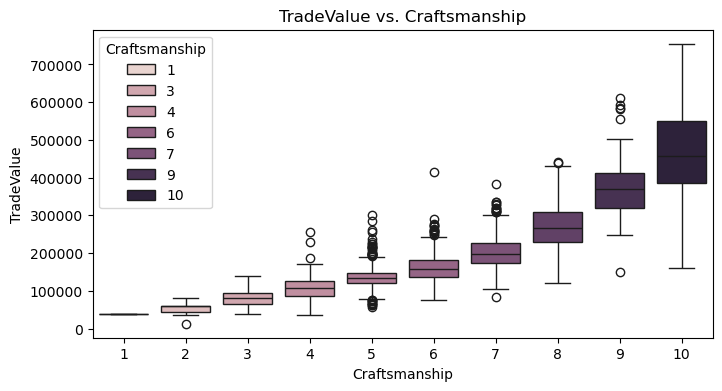

In [301]:
# Boxplot for TradeValue vs. Craftsmanship (ordinal variable)
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='Craftsmanship', y='TradeValue', hue='Craftsmanship')
plt.title('TradeValue vs. Craftsmanship')
plt.show()

Coming to how TradeValue varies across different levels of ExteriorCharm with this boxplot. For the Common charm we see lower median trade value compared to other categories and a wide range of trade values. For the Gleaming charm, there is a higher median trade value than Common, suggesting a positive impact on property value and wider range, meaning there are diverse property values within this category. For the Modest exterior charm, we see a similar structure to Common but with less variability. There are more consistent trade values with fewer outliers. The Enchanting charm has the highest median trade value - strong positive impact on property value, but there is less variability. All of this suggests that aesthetic appeal significantly influences property value.

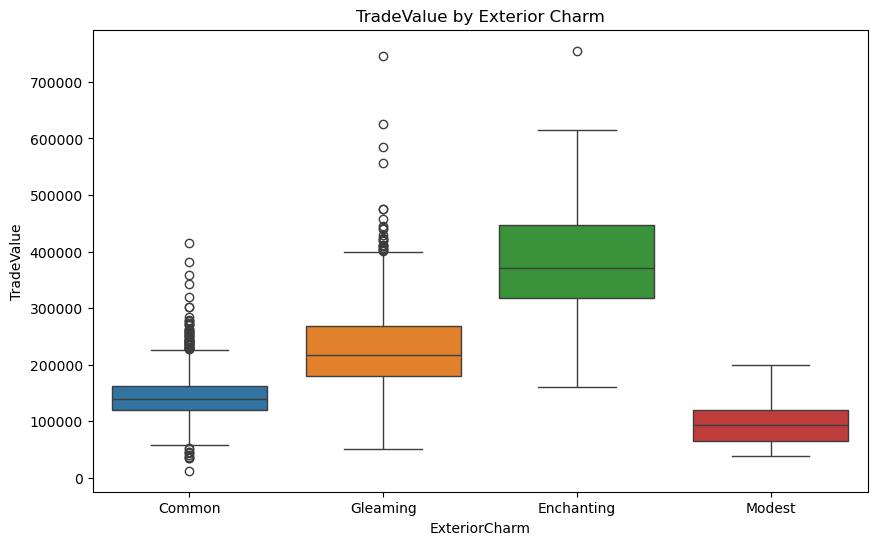

In [302]:
# Boxplot for TradeValue by ExteriorCharm
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='ExteriorCharm', y='TradeValue', hue='ExteriorCharm')
plt.title('TradeValue by Exterior Charm')
plt.show()

Moving forward to restoration and how many properties need one. A significant majority of properties are marked as False for NeedsRestoration, indicating they do not require significant restoration. A much smaller portion of properties are marked as True. This suggests that most properties are in a condition that does not require immediate restoration, which could imply better overall structural integrity or more recent construction dates. 

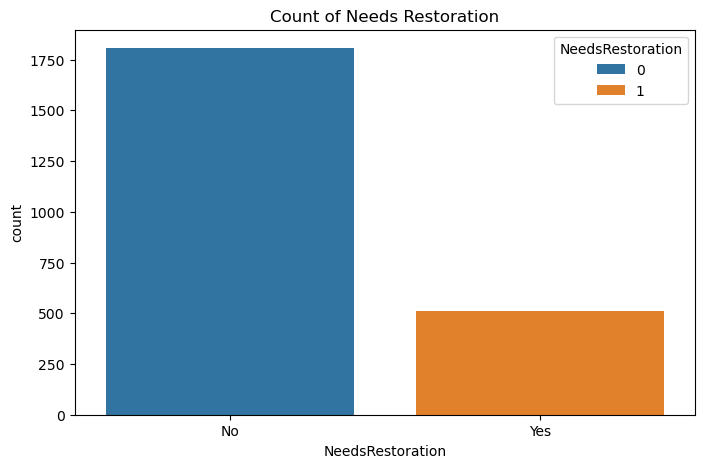

In [303]:
# Count plot for NeedsRestoration
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='NeedsRestoration', hue='NeedsRestoration')
plt.title('Count of Needs Restoration')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

And we can also combine TradeValue and NeedsRestoration, to see how the value varies based on whether a property needs to have a restoration done on it. The properties that don’t need restoration have a higher median trade value compared to those needing restoration. The range of trade values is also broader, which indicates more variability in property values. Accordingly, the properties needing restoration have a lower median trade value, suggesting that restoration needs may decrease property value and the range is narrower, showing more consistency in trade values among properties needing restoration.

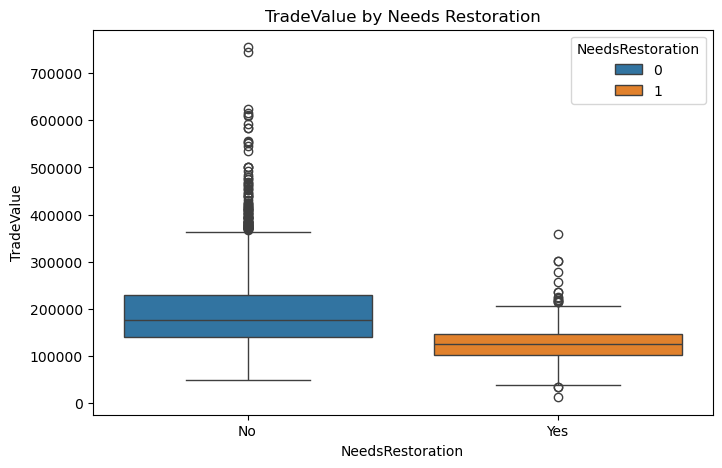

In [304]:
# Boxplot for TradeValue by NeedsRestoration
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='NeedsRestoration', y='TradeValue', hue='NeedsRestoration')
plt.title('TradeValue by Needs Restoration')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

To further analyse what influences the decision to renovate a dwelling or not, we can also combine Craftsmanship and NeedsRestoration. The countplot shows that dwellings with higher craftsmanship ratings are far less likely to require restoration, while those with mid to low craftsmanship levels have a much higher need of restoration. In particular, craftsmanship levels around 5 and below show an increase in properties marked for restoration. This suggests that lower craftsmanship is a strong indicator of restoration necessity.

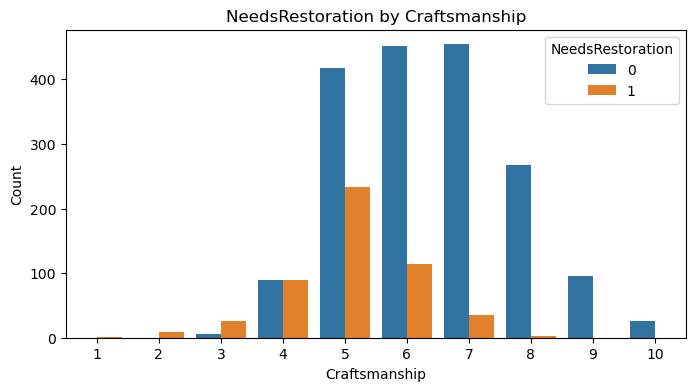

In [305]:
# Countplot for Craftsmanship vs NeedsRestoration
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Craftsmanship', hue='NeedsRestoration')
plt.title('NeedsRestoration by Craftsmanship')
plt.xlabel('Craftsmanship')
plt.ylabel('Count')
plt.show()

Finally, we will see the distribution of properties needing restoration across different enclaves. While most enclaves have a larger number of properties that do not require restoration, certain enclaves like Dragonspire, Petalbridge, and Emberfall show noticeably higher counts of dwellings in need of restoration compared to others. In contrast, enclaves such as Sunspire, Stormhold, and Starfall have very few or no restoration needs. This variation suggests that location plays a significant role in the condition of properties, making Enclave a potentially valuable feature in predicting restoration needs.

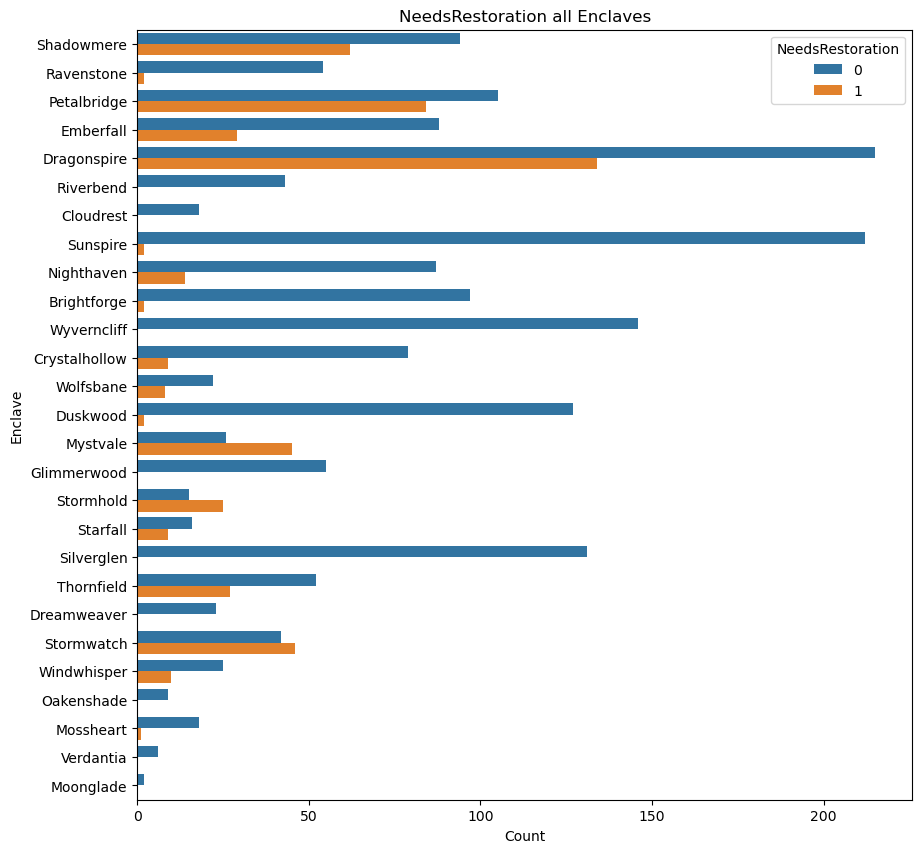

In [306]:
# Countplot for Enclave vs NeedsRestoration (Top 10 most common Enclaves)
top_enclaves = df['Enclave'].value_counts().nlargest(30).index
df_top_enclaves = df[df['Enclave'].isin(top_enclaves)]

plt.figure(figsize=(10, 10))
sns.countplot(data=df_top_enclaves, y='Enclave', hue='NeedsRestoration')
plt.title('NeedsRestoration all Enclaves')
plt.xlabel('Count')
plt.ylabel('Enclave')
plt.show()

## **MODEL**

### Linear regression model

In the linear regression model, we aim to predict the TradeValue of dwellings using a combination of meaningful features. We should first preprocess the data by removing irrelevant or potentially target-leaking columns, such as Downpayment and LoanAmount, and transform nominal variables like ExteriorCharm, Enclave and RealmType using one-hot encoding to make them suitable for modelling. One-hot encoding is a method of converting categorical variables into binary columns so that model can interpret them as numerical input. We decided to use this approach because our categorical features are nominal (unordered) and dropping them would mean losing potentially valuable information for predicting TradeValue (especially considering the correlation between TradeValue and the categorical features described in the data understanding). After splitting the data into training and test sets, we trained a linear regression model.

In [307]:
df_encoded = df.copy()
y = df_encoded['TradeValue']

# One-Hot Encode nominal categorical features
df_encoded = pd.get_dummies(df_encoded, columns=["ExteriorCharm", "RealmType", "Enclave"], drop_first=True)

X = df_encoded.drop(columns=[
    "ParcelSizeUnit", "DI", "TradeValue", "_merge",
    "Downpayment", "LoanAmount", "MonthlyPayment", 
])

# Assign the data (80% of the data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)  

# Fit in the data and trained it to make predictions
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

Afterwards we explore the regression coefficient, which confirm that location and charm have the strongest impact on TradeValue, with properties in Moonglade and those with Enchanting exteriors contributing the most to higher values. Features like AffordableDwelling have a strong negative coefficient, confirming that affordable homes are generally cheaper. Features such as LivingQuarters/ParcelSize have smaller effects.

In [308]:
# Create a dataFrame of coefficients
coefficient = pd.DataFrame({'Feature': X_train.columns,'Coefficient': model.coef_})

# Sort by absolute value
coefficient['AbsCoef'] = coefficient['Coefficient'].abs()
coefficient = coefficient.sort_values(by='AbsCoef', ascending=False).drop(columns='AbsCoef')

print(coefficient)

                     Feature   Coefficient
21         Enclave_Moonglade  84569.405277
7   ExteriorCharm_Enchanting  72959.997746
28         Enclave_Riverbend  65000.996475
20       Enclave_Glimmerwood  57053.087652
30        Enclave_Silverglen  48605.417844
3         AffordableDwelling -40568.552426
39       Enclave_Wyverncliff  23504.485667
27        Enclave_Ravenstone  18622.580052
22         Enclave_Mossheart  15736.989384
13     RealmType_Meadowlands  14778.917622
17       Enclave_Dreamweaver  14612.403776
4              Craftsmanship  13533.678353
35        Enclave_Thornfield  13046.193781
15     Enclave_Crystalhollow   9071.436365
31          Enclave_Starfall  -8776.206385
32         Enclave_Stormhold  -8622.309197
14         Enclave_Cloudrest  -8306.663794
11  RealmType_CitadelQuarter   7767.143383
26       Enclave_Petalbridge  -7349.212213
34          Enclave_Sunspire   6752.984915
29        Enclave_Shadowmere  -6594.349006
25        Enclave_Oakenshade   5889.056872
16       En

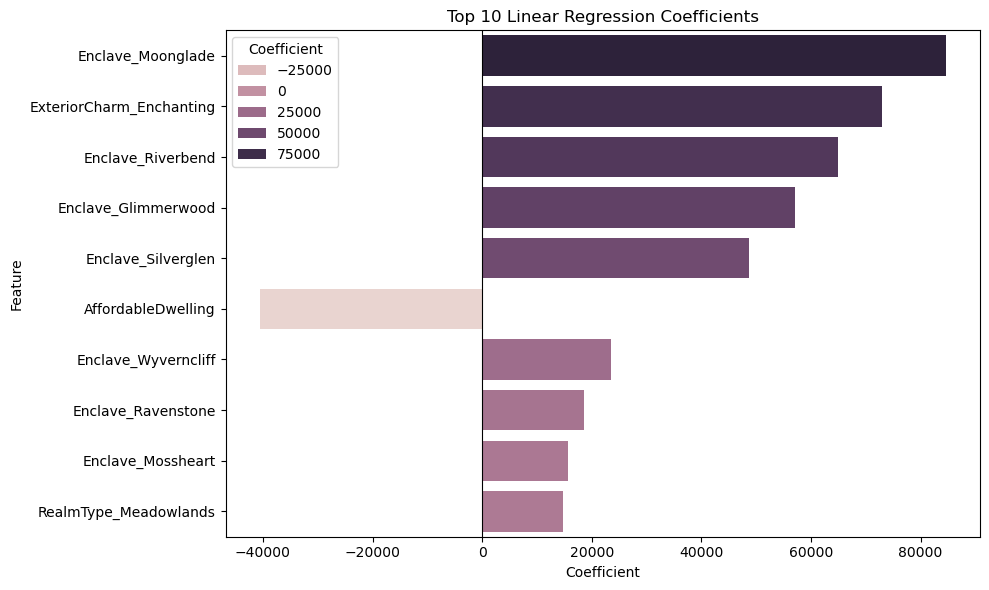

In [309]:
plt.figure(figsize=(10, 6))
sns.barplot(data=coefficient.head(10), x='Coefficient', y='Feature', hue='Coefficient')
plt.title('Top 10 Linear Regression Coefficients')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

## **Evaluation - Linear Regression Model**

In [310]:
# After the predictions we are using metrics such as Mean Absolute Error and Mean squared error to see what the efficiency of our model is both on the train and the test data
print(f"MAE - Mean Absolute Error")
print(f"MAE for the linear model on the test set: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"MAE for the linear model on the training set: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"\nMSE - Mean Square Error")
print(f"MSE for the linear model on the test set: {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"MSE for the linear model on the training set: {mean_squared_error(y_train, y_pred_train):.2f}")
print(f"\nRMSE - Root Mean Square Error")
print(f"RMSE for the linear model on the test set: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"RMSE for the linear model on the training set: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

MAE - Mean Absolute Error
MAE for the linear model on the test set: 20470.13
MAE for the linear model on the training set: 19446.31

MSE - Mean Square Error
MSE for the linear model on the test set: 1104503677.47
MSE for the linear model on the training set: 966553342.26

RMSE - Root Mean Square Error
RMSE for the linear model on the test set: 33234.07
RMSE for the linear model on the training set: 31089.44


The linear regression model performs significantly better than our initial baseline model, which simply predicted the median TradeValue and resulted in a high MAE of 54,499 and MSE of over 6.5 billion. In contrast, our improved model achieved a much lower MAE of 20,470 and MSE of approximately 1.1 billion on the test set, indicating a more accurate and reliable prediction of trade values. This model demonstrates consistent performance across training and test data, with no clear signs of overfitting. We can conclude that key factors influencing TradeValue are the size of the LivingQuarters, the Enclave and RealmType the dwelling belongs to, and the ExteriorCharm. All of these features were found out as important during data understanding and confirmed through the model’s coefficients. These features capture the essence of what makes a property more or less valuable in this housing market.

## **MODEL**

### Classification model - using tree
A decision tree model is made to classify whether a dwelling needs restoration. The decision tree structure is vizualized.

Since the majority class is "No restoration," we use a benchmark model that always predicts False (no restoration). This reflects the class imbalance in our dataset and helps evaluate whether our model performs better than a naïve guess.

In [311]:
# Always predict "No restoration" (False)
y_pred_benchmark = [False] * len(target_test)
benchmark_accuracy = accuracy_score(target_test, y_pred_benchmark)
benchmark_recall = recall_score(target_test, y_pred_benchmark)
print(f"Benchmark accuracy: {benchmark_accuracy:.2f}")
print(f"Benchmark recall: {benchmark_recall:.2f}")

Benchmark accuracy: 0.78
Benchmark recall: 0.00


In the decision tree classifier model, the goal is to predict whether a dwelling needs restoration. The model was trained using a shallow decision tree with a limited depth to maintain interpretability and avoid overfitting. Key predictors such as EraConstructed, Craftsmanship, and TradeValue were used to split the data. The model achieved high recall, correctly identifying all properties that require restoration, though with moderate precision, indicating some over-prediction. This trade-off is acceptable as catching all at-risk properties is more important than avoiding a few false positives

In [312]:
features = df[['TradeValue', 'Craftsmanship', 'EraConstructed']]
target = df['NeedsRestoration']
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)  

model = tree.DecisionTreeClassifier(
    max_depth=2,
    min_samples_leaf=10,
    # penalize false positives more
    class_weight={True: 1, False: 0.5},  
    random_state=42
)
model.fit(feature_train, target_train)
y_pred_test = model.predict(feature_test)
y_pred_train = model.predict(feature_train)

print(f'Accuracy for the train set: {np.sqrt(accuracy_score(target_train, y_pred_train)):.2f}')
print(confusion_matrix(target_train, y_pred_train, normalize='all', labels=[True, False]))
print(f'Accuracy for the test set: {np.sqrt(accuracy_score(target_test, y_pred_test)):.2f}')
print(confusion_matrix(target_test, y_pred_test, normalize='all', labels=[True, False]))

Accuracy for the train set: 0.94
[[0.2188656  0.00308261]
 [0.12083847 0.65721332]]
Accuracy for the test set: 0.94
[[0.21408046 0.00287356]
 [0.11206897 0.67097701]]


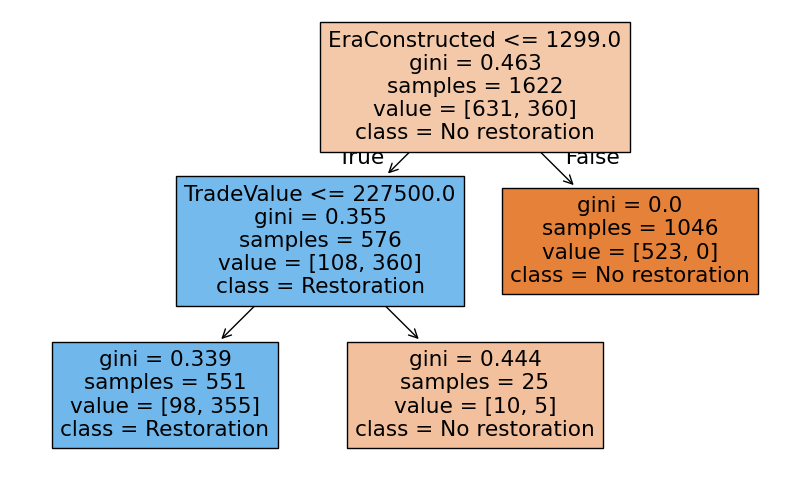

In [313]:
plt.figure(figsize=(10,6))
tree.plot_tree(model, feature_names=features.columns, class_names=['No restoration', 'Restoration'], filled=True)
plt.show()

## **Evaluation - classification model using tree**

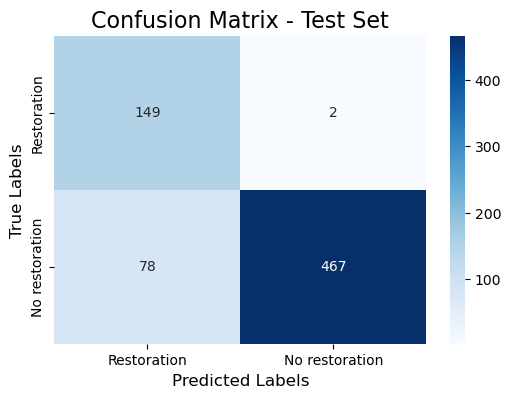

In [314]:
cm = confusion_matrix(target_test, y_pred_test, labels=[True, False])

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Restoration', 'No restoration'],
            yticklabels=['Restoration', 'No restoration'])
plt.title('Confusion Matrix - Test Set', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

In [315]:
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(target_test, y_pred_test)
precision = precision_score(target_test, y_pred_test)
recall = recall_score(target_test, y_pred_test)
f1 = f1_score(target_test, y_pred_test)
roc_auc = roc_auc_score(target_test, y_pred_test)
misclassification_rate = (FP + FN) / (TP + TN + FP + FN)

print(f"Accuracy: {round(accuracy, 2)}")
print(f"Precision: {round(precision, 2)}")
print(f"Recall: {round(recall, 2)}")
print(f"F1 Score: {round(f1, 2)}")
print(f"Misclassification Rate: {round(misclassification_rate, 2)}")

Accuracy: 0.89
Precision: 0.66
Recall: 0.99
F1 Score: 0.79
Misclassification Rate: 0.11


Based on the metrics, our model achieved an accuracy of 89%, a recall of 99%, and an F1 Score of 0.79, all of which meet or exceed the success criteria. However, the precision of 66% falls below the 85% target, indicating room for improvement in reducing false positives. This trade-off is acceptable as catching all at-risk properties is more important than avoiding some false alarms. The misclassification rate is 11%, which stays within the acceptable range (≤ 15%). The key indicators influencing restoration needs are primarily EraConstructed and TradeValue, with older and lower-valued dwellings being far more likely to require restoration. Compared to our benchmark model that always predicts "No restoration" (84.1% accuracy but 0% recall), our model clearly performs better by identifying nearly all true cases.